## Importing Dataset + Visualization

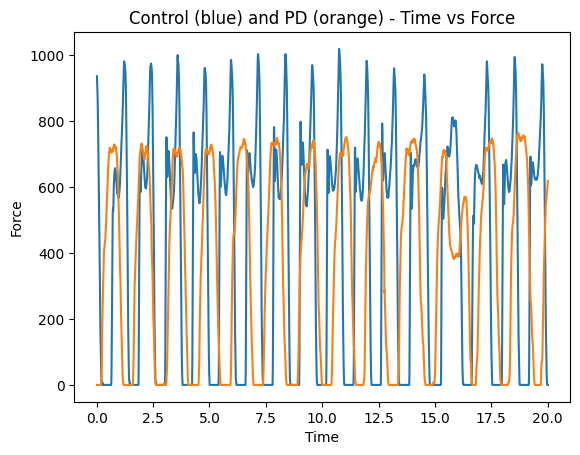

In [2]:
# This file will be used to start developping the preprocessing of the data pipeline
# Consisting of feature selection and dimension reduction

import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt

# Import dataset
features = ['Time', 'Left Foot Force', 'Right Foot Force']
dataset_dir_control = "csv_averaged_force_data_4col/GaCo04_01.csv"
dataset_dir_pd = "csv_averaged_force_data_4col/GaPt03_01.csv"

# Read the csv
df_control = pd.read_csv(dataset_dir_control).head(2001)
df_control.columns = features

df_pd = pd.read_csv(dataset_dir_pd).head(2001)
df_pd.columns = features

# Plotting a subset of the data
fname = 'Right Foot Force'

plt.xlabel('Time')
plt.ylabel('Force')
plt.title('Control (blue) and PD (orange) - Time vs Force')
plt.plot(df_control.Time, df_control[fname])
plt.plot(df_pd.Time, df_pd[fname])
plt.show()

## All Datasets calculating Stride Time

In [ ]:
for name in os.listdir('csv_averaged_force_data_4col'):
    if 'Co' in name or 'Pt' in name:

        features = ['Time', 'Left Foot Force', 'Right Foot Force']
        df = pd.read_csv('csv_averaged_force_data_4col/' + name)
        df.columns = features
        
        t_strideIntervals = []
        startTime = None

        # Calculating stride time 
        for index, row in df.iterrows():
            
            # This means that the stride has been initiated 
            if (row[features[2]] == 0) & (startTime is None):
                startTime = row[features[0]]
            
            # This means that the stride has been stopped
            elif (row[features[2]] != 0) & (startTime is not None):
                t_strideIntervals.append((startTime, row[features[0]]))
                startTime = None
        
            # Duration of each interval
            t_strideDurations = [(end - start) for start,end in t_strideIntervals]

            # Converting the data into a pandas dataframe
            strideTime = np.array(t_strideDurations)
            df_strideTime = pd.DataFrame(strideTime)

        nameStrideTime = 'StrideFiles/StrideTime' + name.split('.')[0] + ".csv"
        df_strideTime.to_csv(nameStrideTime, index = None)
        
 

## Extracting Stride Time (Individual Set Comparing )

In [4]:
df_control = pd.read_csv(dataset_dir_control)
df_control.columns = features

df_pd = pd.read_csv(dataset_dir_pd)
df_pd.columns = features


## To calculate the time of each stride we can calculate the time between each zero force plateau 

### FOR PD PATIENT
t_strideIntervals_pd = []
startTime_pd = None

for index, row in df_pd.iterrows():
    
    # This means that the stride has been initiated 
    if (row[features[2]] == 0) & (startTime_pd is None):
        startTime_pd = row[features[0]]
    
    # This means that the stride has been stopped
    elif (row[features[2]] != 0) & (startTime_pd is not None):
        t_strideIntervals_pd.append((startTime_pd, row[features[0]]))
        startTime_pd = None
    
# Duration of each interval
t_strideDurations_pd = [(end - start) for start,end in t_strideIntervals_pd]

print("The PD Patient had a stride time average of " + str(np.mean(t_strideDurations_pd)) + " and a standard deviation of " + str(np.std(t_strideDurations_pd)))
print(len(t_strideDurations_pd))


### FOR CONTROL PATIENT
t_strideIntervals_control = []
startTime_control = None

for index, row in df_control.iterrows():
    
    # This means that the stride has been initiated 
    if (row[features[2]] == 0) & (startTime_control is None):
        startTime_control = row[features[0]]
    
    # This means that the stride has been stopped
    elif (row[features[2]] != 0) & (startTime_control is not None):
        t_strideIntervals_control.append((startTime_control, row[features[0]]))
        startTime_control = None
    
# Duration of each interval
t_strideDurations_control = [(end - start) for start,end in t_strideIntervals_control]

# for interval, duration in zip(t_strideIntervals_pd, t_strideDurations_control):
#     print(f"Zero force interval: {interval}, Duration: {duration} units of time")


print("The PD Patient had a stride time average of " + str(np.mean(t_strideDurations_control)) + " and a standard deviation of " + str(np.std(t_strideDurations_control)))
print(len(t_strideDurations_control))

The PD Patient had a stride time average of 0.3484404761904764 and a standard deviation of 0.12792789088560738
84
The PD Patient had a stride time average of 0.39366407766990313 and a standard deviation of 0.09038361808604442
103
